# Template Modelling using Probabilistic Circuits

Reasoning over dynamic worlds is often done by template models, such as the [Hidden Markov Model (HMM)](https://en.wikipedia.org/wiki/Hidden_Markov_model). 
The HMM is the most prominent instance of applying factor mathematics to probabilistic models. Long story short, the [chain rule](https://en.wikipedia.org/wiki/Chain_rule_(probability))
combined with [conditional independence](https://en.wikipedia.org/wiki/Conditional_independence) allows for probabilistic graphical models to be (efficiently) expanded over dynamic domains, such as time.

Doing so with complex random variables which distribution is described by a probabilistic circuit also allows for dynamic expansions. 
The latent variable interpretation of a sum unit $\sum_i \theta_i p_i(x) = P(i) P(x | i)$ is a reinterpretation of a circuit as a graphical model with a hidden (latent) variable.
Naturally, connecting the hidden variables of sum units gives rise to template based circuits.
Consider the following distribution:

In [28]:
import portion
import random
random.seed(69)
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from random_events.events import VariableMap, Event
from random_events.variables import Continuous

from probabilistic_model.probabilistic_circuit.distributions import *
from probabilistic_model.learning.nyga_distribution import NygaDistribution
from probabilistic_model.probabilistic_model import ProbabilisticModel


x = Continuous("x")

model = NygaDistribution(x)
model.add_subcircuit(UniformDistribution(x, portion.closed(-1.5, -0.5)), 0.5)
model.add_subcircuit(UniformDistribution(x, portion.closed(0.5, 1.5)), 0.5)
go.Figure(model.plot(), layout=model.plotly_layout()).show()

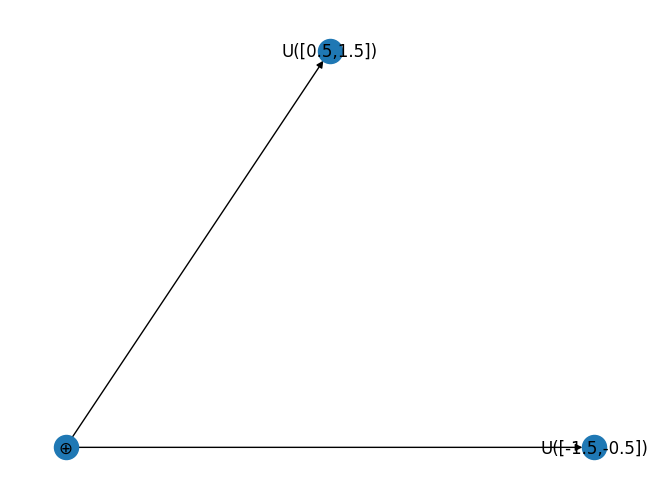

In [29]:
def show_structure(model):
    pos = nx.planar_layout(model)
    nx.draw(model, pos=pos, with_labels=True)
    plt.show()
    
show_structure(model.probabilistic_circuit)

Let's now expand this distribution over time such that $x$ will flip the sign at each timestep.
We can do so, by describing the latent variable interaction in the following way.

In [30]:
import numpy as np
from probabilistic_model.distributions.multinomial import MultinomialDistribution
import tabulate

probabilities = np.array([[0, 0.5], 
                          [0.5, 0]])

next_model = model.__copy__()
transition_model = MultinomialDistribution([model.latent_variable, next_model.latent_variable], probabilities)
print(tabulate.tabulate(transition_model.to_tabulate(), tablefmt="fancy_grid"))

╒════════════════════════╤════════════════════════╤═════╕
│ 139885311175264.latent │ 139885311288224.latent │ P   │
├────────────────────────┼────────────────────────┼─────┤
│ 0                      │ 0                      │ 0.0 │
├────────────────────────┼────────────────────────┼─────┤
│ 0                      │ 1                      │ 0.5 │
├────────────────────────┼────────────────────────┼─────┤
│ 1                      │ 0                      │ 0.5 │
├────────────────────────┼────────────────────────┼─────┤
│ 1                      │ 1                      │ 0.0 │
╘════════════════════════╧════════════════════════╧═════╛


Now we can create the markov chain of our distribution over $x$ with respect to the transition model.

In [31]:
def expand_model(base_model: NygaDistribution, transition_model: ProbabilisticModel, number_of_timesteps: int) -> NygaDistribution:
    """
    Expand a model along the time domain.
    :param base_model: The model to expand
    :param transition_model: The interaction model between their latent variables
    :param number_of_timesteps: The amount of timesteps to create
    :return: The expanded model
    """
    
    # initialize current and previous model
    current_model = None
    previous_model = None
    
    # for every timestep
    for i in range(number_of_timesteps):
        
        # copy model
        current_model = base_model.__copy__()
        
        # update variables in model
        current_variable = Continuous(f"x{i}")
        variable_update = VariableMap({current_model.variable: current_variable})
        current_model.update_variables(variable_update)
        
        # if this is not the first iteration
        if previous_model is not None:
            
            # update variables in transition model
            transition_model.variables = [previous_model.latent_variable, current_model.latent_variable]
            
            # expand model
            current_model.mount_with_interaction_terms(previous_model, transition_model)
            
        # update previous model
        previous_model = current_model
    
    return current_model

expanded_model = expand_model(model.__copy__(), transition_model, 2)

Lets now sample from our expanded model to get a feel on how it behaves over time.

In [32]:
samples = np.array(expanded_model.probabilistic_circuit.sample(2))

def plot_samples(samples: np.ndarray) -> go.Figure:
    """
    Plot samples through time.
    :param samples: The samples to plot 
    :return: The figure
    """
    fig = go.Figure()
    timesteps = list(range(samples.shape[1]))
    for point in samples:
        fig.add_trace(go.Scatter(x = timesteps, y=point, mode="lines+markers", name=""))
    fig.update_layout(title="Traces through the construct probability space", yaxis_title="x", xaxis_title="Timestep")
    fig.update_xaxes(tickvals=timesteps)
    return fig

plot_samples(samples).show()

We can see that indeed for our two samples the sign flipped as desired. Looking at the structure, we can see that the size of the circuit grew only linearly in the number of timesteps, while being a tractable, full joint distribution over the sequence. Wow!

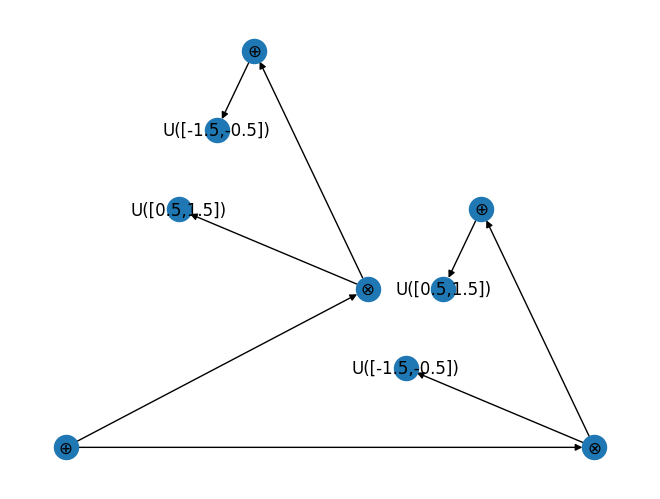

In [33]:
show_structure(expanded_model.probabilistic_circuit)

Scaling this idea to more timesteps yields a fast and efficient markov chain with linear many parameters and linear inference time. 

In [34]:
expanded_model = expand_model(model.__copy__(), transition_model, 20)
samples = np.array(expanded_model.sample(2))
plot_samples(samples).show()

In [35]:
print(expanded_model.probabilistic_circuit)

ProbabilisticCircuit with 117 nodes and 116 edges


Furthermore, all inference methods still work as usually.

In [36]:
print("Probability of everything:", expanded_model.probability(Event()))
print("-" * 80)
print("Expectation:", expanded_model.expectation(expanded_model.variables))
print("-" * 80)
modes, ml = expanded_model.mode()
print("First possible Mode:", modes[0])
print("-" * 80)
print("Second possible Mode:", modes[1])

Probability of everything: 1.0
--------------------------------------------------------------------------------
Expectation: {Continuous(x0): 0.0, Continuous(x1): 0.0, Continuous(x10): 0.0, Continuous(x11): 0.0, Continuous(x12): 0.0, Continuous(x13): 0.0, Continuous(x14): 0.0, Continuous(x15): 0.0, Continuous(x16): 0.0, Continuous(x17): 0.0, Continuous(x18): 0.0, Continuous(x19): 0.0, Continuous(x2): 0.0, Continuous(x3): 0.0, Continuous(x4): 0.0, Continuous(x5): 0.0, Continuous(x6): 0.0, Continuous(x7): 0.0, Continuous(x8): 0.0, Continuous(x9): 0.0}
--------------------------------------------------------------------------------
First possible Mode: {Continuous(x14): [0.5,1.5], Continuous(x16): [0.5,1.5], Continuous(x10): [0.5,1.5], Continuous(x1): [-1.5,-0.5], Continuous(x9): [-1.5,-0.5], Continuous(x6): [0.5,1.5], Continuous(x0): [0.5,1.5], Continuous(x4): [0.5,1.5], Continuous(x11): [-1.5,-0.5], Continuous(x15): [-1.5,-0.5], Continuous(x5): [-1.5,-0.5], Continuous(x8): [0.5,1.5], Co

While this example is fairly simple, the concept of dynamic expansions of circuits into full joint distributions without any additional constraints on circuits is a potent idea.